## Validation and transfer learning on the PTB dataset

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import sklearn
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from functions import evaluate_model, plot_confusion_matrix, get_transfer_model

In [7]:
model_resnet = keras.models.load_model('models/best_model_resnet.h5')
model_lstm = keras.models.load_model('models/best_model_lstm.h5')

2022-09-05 17:26:45.745350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
ptbdb_abnormal = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("data/ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_normal,ptbdb_abnormal], axis=0, ignore_index=True)

In [9]:
target_val=ptbdb[187]
y_val=to_categorical(target_val)
y_val=tf.argmax(y_val, axis=-1)

In [10]:
X_val=ptbdb.iloc[:,:186].values
X_val = X_val.reshape(len(X_val), X_val.shape[1],1)

In [11]:
y_pred=model_resnet.predict(X_val)

455/455 [==============================] - 3s 7ms/step


In [12]:
def map_to_binary(pred,array=True):
    new_pred=[]
    for e in pred:
        if e.argmax() == 0:
            new_pred.append(0)
        else:
            new_pred.append(1)
    if array==True:
        new_pred=np.asarray(new_pred)
    return new_pred
    

In [13]:
y_pred=map_to_binary(y_pred)

In [14]:
y_pred2=1-y_pred

Confusion matrix, without normalization
[[ 586 3460]
 [3663 6843]]


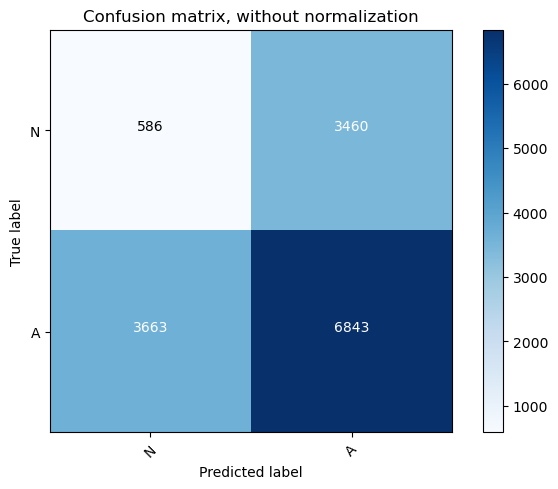

In [15]:
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_val, y_pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'A'],
                      title='Confusion matrix, without normalization')

In [16]:
### Divide test and train

In [17]:
X_ptbdb_train, X_ptbdb_test, y_ptbdb_train, y_ptbdb_test = \
train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)

In [18]:
X_train=X_ptbdb_train[:,:186]
X_test=X_ptbdb_test[:,:186]

In [19]:
X_ptbdb_train = X_train.reshape(len(X_train), (X_train.shape[1]),1)
X_ptbdb_test = X_test.reshape(len(X_test), (X_test.shape[1]),1)

In [28]:
### RESNET model trained on MIT against PTB test

In [24]:
y_pred=model_resnet.predict(X_ptbdb_test)
y_pred=map_to_binary(y_pred)
y_pred2=1-y_pred

print('Accuracy:', accuracy_score(y_ptbdb_test, y_pred2))

91/91 [==============================] - 1s 7ms/step
Accuracy: 0.5115080728272071


### Transfer learning

In [13]:
get_transfer_model(model_resnet).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs_resnet (InputLayer)     [(None, 186, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 186, 32)      192         ['inputs_resnet[0][0]']          
                                                                                                  
 re_lu (ReLU)                   (None, 186, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 186, 32)      5152        ['re_lu[0][0]']                  
                                                                                              

In [17]:
transfer_model_resnet = get_transfer_model(model_resnet)

save_best_weights = ModelCheckpoint(filepath="models/tweights_resnet.hdf5", verbose=0, save_best_only=True)

transfer_model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model_resnet.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_test, y_ptbdb_test), 
                             shuffle=True, batch_size=32,epochs=40, callbacks=[save_best_weights])

Epoch 1/40
364/364 [==============================] - 5s 12ms/step - loss: 0.4333 - accuracy: 0.7861 - val_loss: 0.3866 - val_accuracy: 0.8172
Epoch 2/40
364/364 [==============================] - 3s 10ms/step - loss: 0.3446 - accuracy: 0.8436 - val_loss: 0.3325 - val_accuracy: 0.8592
Epoch 3/40
364/364 [==============================] - 4s 11ms/step - loss: 0.2973 - accuracy: 0.8729 - val_loss: 0.3050 - val_accuracy: 0.8763
Epoch 4/40
364/364 [==============================] - 4s 10ms/step - loss: 0.2697 - accuracy: 0.8815 - val_loss: 0.2858 - val_accuracy: 0.8842
Epoch 5/40
364/364 [==============================] - 4s 10ms/step - loss: 0.2470 - accuracy: 0.8967 - val_loss: 0.2671 - val_accuracy: 0.8880
Epoch 6/40
364/364 [==============================] - 4s 11ms/step - loss: 0.2285 - accuracy: 0.9051 - val_loss: 0.2588 - val_accuracy: 0.9038
Epoch 7/40
364/364 [==============================] - 4s 10ms/step - loss: 0.2177 - accuracy: 0.9096 - val_loss: 0.2360 - val_accuracy: 0.9069

Accuracy: 92.96%


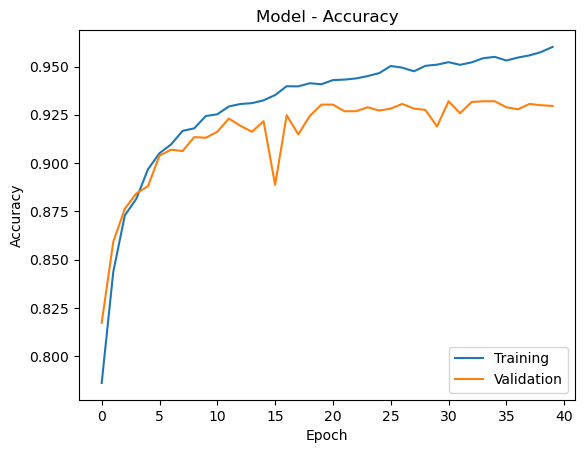

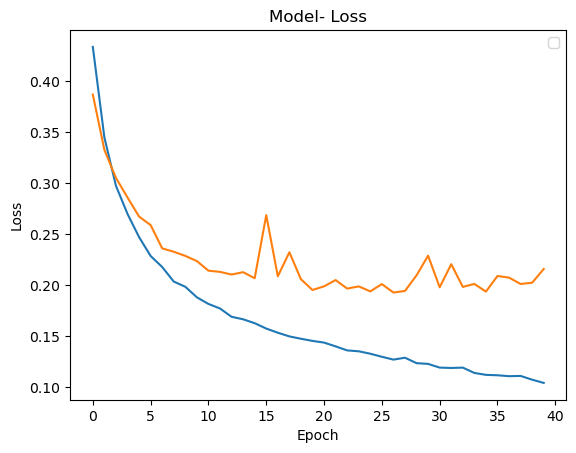

91/91 [==============================] - 1s 6ms/step


In [18]:
evaluate_model(history,X_ptbdb_test,y_ptbdb_test,transfer_model_resnet)

### Repeat the analysis for the LSTM model

In [22]:
y_pred=model_lstm.predict(X_val)
y_pred=map_to_binary(y_pred)
y_pred2=1-y_pred

455/455 [==============================] - 42s 89ms/step


Confusion matrix, without normalization
[[1097 2949]
 [4315 6191]]


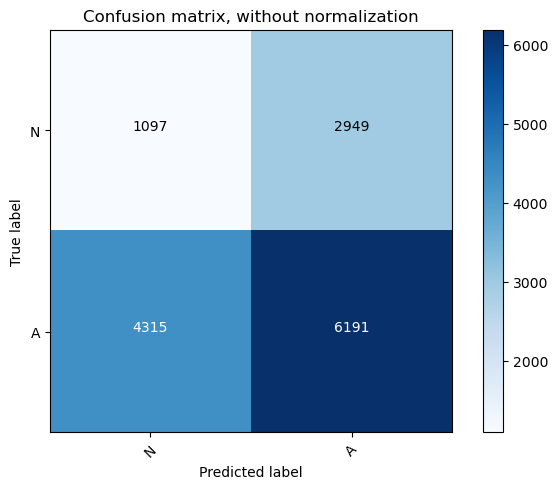

In [23]:
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_val, y_pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'A'],
                      title='Confusion matrix, without normalization')

In [26]:
### LSTM best model trained on MIT against PTB test

In [25]:
y_pred=model_lstm.predict(X_ptbdb_test)
y_pred=map_to_binary(y_pred)
y_pred2=1-y_pred

print('Accuracy:', accuracy_score(y_ptbdb_test, y_pred2))

91/91 [==============================] - 9s 80ms/step
Accuracy: 0.5029199587770525


In [24]:
get_transfer_model(model_lstm).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_lstm (InputLayer)    [(None, 186, 1)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 186, 128)         33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 186, 128)         98816     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 23808)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                761888    
                                                                 
 dense_7 (Dense)             (None, 32)                1056

In [25]:
transfer_model_resnet = get_transfer_model(model_lstm)

save_best_weights = ModelCheckpoint(filepath="models/tweights_lstm.hdf5", verbose=0, save_best_only=True)

transfer_model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model_resnet.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_test, y_ptbdb_test), 
                             shuffle=True, batch_size=32,epochs=40, callbacks=[save_best_weights])

Epoch 1/40
364/364 [==============================] - 48s 117ms/step - loss: 0.3418 - accuracy: 0.8453 - val_loss: 0.2553 - val_accuracy: 0.8983
Epoch 2/40
364/364 [==============================] - 41s 113ms/step - loss: 0.2130 - accuracy: 0.9121 - val_loss: 0.1895 - val_accuracy: 0.9258
Epoch 3/40
364/364 [==============================] - 42s 114ms/step - loss: 0.1662 - accuracy: 0.9347 - val_loss: 0.1941 - val_accuracy: 0.9141
Epoch 4/40
364/364 [==============================] - 39s 107ms/step - loss: 0.1332 - accuracy: 0.9503 - val_loss: 0.1617 - val_accuracy: 0.9375
Epoch 5/40
364/364 [==============================] - 42s 117ms/step - loss: 0.1147 - accuracy: 0.9558 - val_loss: 0.1300 - val_accuracy: 0.9495
Epoch 6/40
364/364 [==============================] - 42s 116ms/step - loss: 0.0995 - accuracy: 0.9625 - val_loss: 0.1654 - val_accuracy: 0.9392
Epoch 7/40
364/364 [==============================] - 45s 124ms/step - loss: 0.0879 - accuracy: 0.9660 - val_loss: 0.0997 - val_ac

Accuracy: 97.70%


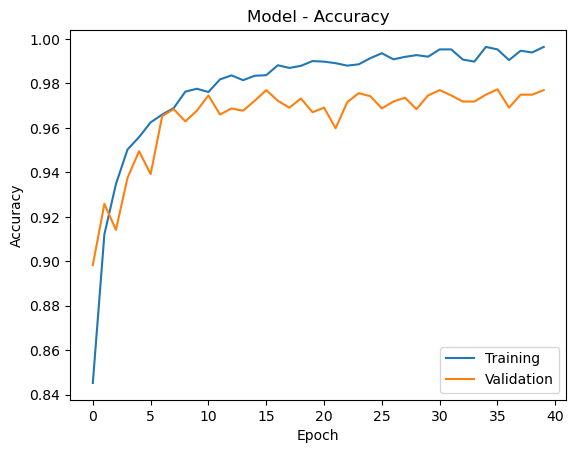

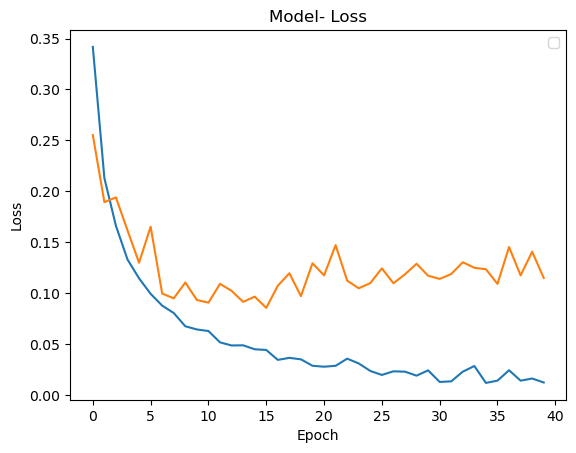

91/91 [==============================] - 8s 74ms/step


In [26]:
evaluate_model(history,X_ptbdb_test,y_ptbdb_test,transfer_model_resnet)